<center>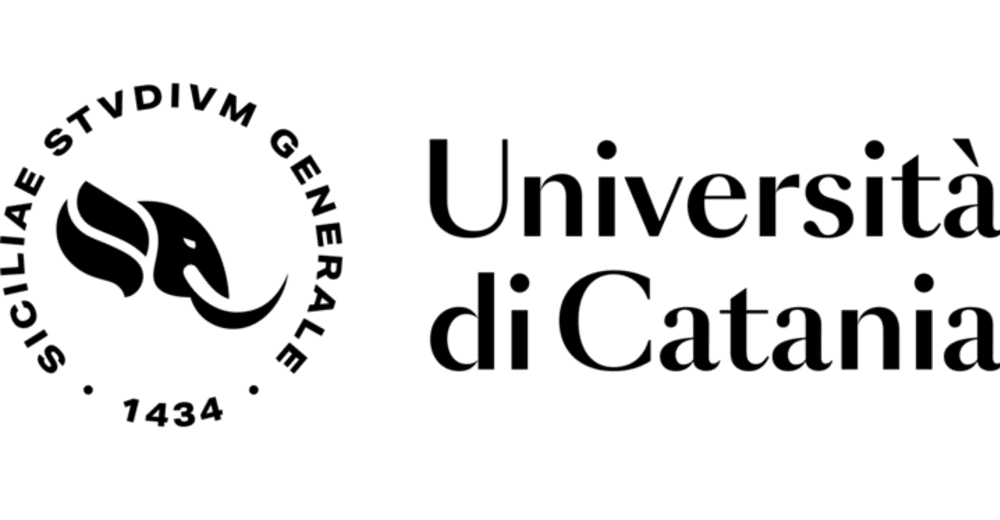

<center><h3>DATA SCIENCE FOR MANAGEMENT - LM 91</h3>
<h1>Synthetic digits Classification using Fully Convolutional Networks</h1>

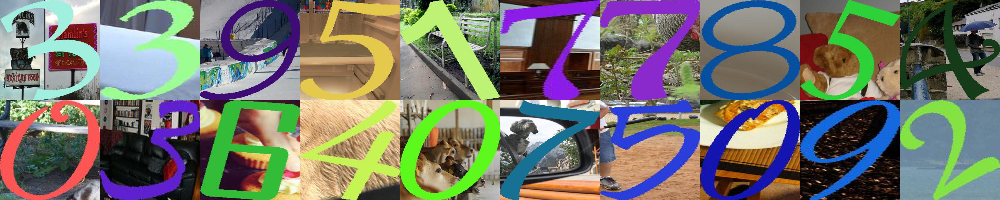

## 1. Introduction

### 1.1 Introduction

The aim of this homework is to understand and build FCN models using PyTorch. The dataset used contains 12,000 synthetically generated images of English digits embedded on random backgrounds (randomly selected from a subset of COCO dataset). The images are generated with varying fonts, colors, scales and rotations.

### 1.2 Required libraries

The first step is to install on the VM the Kaggle library to download the dataset:

In [ ]:
!pip install kaggle

Then we load all the libraries that will be used during the analysis:

In [ ]:
import os

import torch
import torch.nn as nn
import torchvision
from torchvision import *
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

At this step we need generate the token from the Kaggle account (Sign in -> Account -> Create api token) and upload it to the VM (the token will be moved to another folder called "kaggle" and it is no more accessible to users).

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


### 1.3 Download the dataset

Now we can download the dataset:

In [ ]:
!kaggle datasets download -d prasunroy/synthetic-digits

 98% 226M/232M [00:08<00:00, 28.3MB/s]
100% 232M/232M [00:08<00:00, 28.6MB/s]


Unzip it, avoiding to zip the data folder (which is a copy of synthetic_digits folder):

In [ ]:
!unzip -q ./synthetic-digits.zip -x "*data*"

Here we remove the .zip file dataset and the sample data provided by Google Colab. Also, we rename the dataset into training and test set.

In [ ]:
!rm -rf sample_data #Remove folder sample_data
!rm synthetic-digits.zip # Remove the zip file downloaded
!mv ./synthetic_digits/imgs_valid ./synthetic_digits/test #Rename in test set
!mv ./synthetic_digits/imgs_train ./synthetic_digits/train #Rename in train set

## 2. The dataset

### 2.1 Dataset information

Let's have a look at what there is inside the training and test set folders and the number of sample for each folder:

In [ ]:
dir = './synthetic_digits/'

for split in ['train', 'test']:
  print("Folders inside " + split + " set: ", len(os.listdir(dir + split)))
  print(sorted(os.listdir(dir + split)))
  
  print("Total number of samples in " + split + " set: ", sum(len(files) for _, _, files in os.walk(dir + split)))
  
  print("Number of images for each folder")
  for cls in sorted(os.listdir(dir + split)):
    print(cls, ':', len(os.listdir(dir + split + '/' + cls)))
  print()
  

Folders inside train set:  10
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Total number of samples in train set:  10000
Number of images for each folder
0 : 1000
1 : 1000
2 : 1000
3 : 1000
4 : 1000
5 : 1000
6 : 1000
7 : 1000
8 : 1000
9 : 1000

Folders inside test set:  10
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Total number of samples in test set:  2000
Number of images for each folder
0 : 200
1 : 200
2 : 200
3 : 200
4 : 200
5 : 200
6 : 200
7 : 200
8 : 200
9 : 200



As we can see there are 10 folders, both in train and test sets, named as the digits applied to the images. Training set contains 10000 samples (1000 samples for each class) and test set contains 2000 samples (200 for each class), both sets are balanced.

### 2.2 Preparing the dataset to be analyzed

Considering that samples provided within the dataset have various dimensions, we decided to resize them all to 32x32, applying a normalization with mean and standard deviation at 0.5. Normalize will bring the image in the range [-1,1] and this could be helpful for the CNN.

In [ ]:
transform = T.Compose([
          T.Resize((32, 32)),
          T.ToTensor(),
          T.Normalize(0.5, 0.5)
])

Apply the transformation to training and test set:

In [ ]:
train_set = datasets.ImageFolder(dir + "train", transform=transform)
test_set = datasets.ImageFolder(dir + "test", transform=transform)

Remembering that the number of samples in the training set is 10000 and 2000 in the test set, we can build a validation set taking 20% of samples from the training set:

In [ ]:
train_split = 0.2
lengths = [int(len(train_set)*train_split), int(len(train_set)*(1-train_split))]
val_set, train_set = torch.utils.data.random_split(train_set, lengths)

# Dataset len
num_train = len(train_set)
num_val = len(val_set)
num_test = len(test_set)
print(f"Number of training samples:   {num_train}")
print(f"Number of validation samples: {num_val}")
print(f"Number of test samples:       {num_test}")

Number of training samples:   8000
Number of validation samples: 2000
Number of test samples:       2000


Now we can define how to load the data and we decided to load them with a batch size of 32 without drop the last batch.

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=False, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, drop_last=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, drop_last=False, num_workers=2)

And as we can see the data from training set have been loaded correctly and we have a tensor of 32x3x32x32, which means:
*   Batch size: 32
*   Channels: 3 (RGB)
*   Height: 32px
*   Width: 32px

In [ ]:
inputs, labels = next(iter(train_loader))
print(inputs.shape)
print(labels.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


### 2.3 Image samples

And now we can see 32 samples in the first batch loaded:

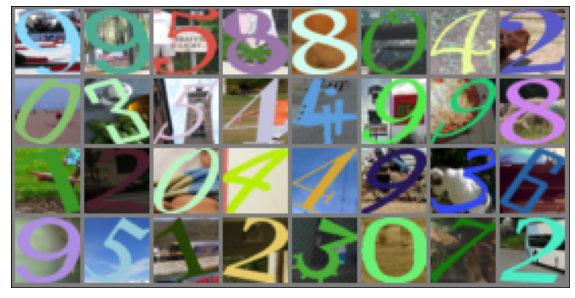

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig= plt.figure(figsize=(10,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(inputs))

## 3. Fully Convolutional Network

Fully Convolutional Network (or FCN) is a network that does not contain any dense layer, as in traditional Convolutional Neural Network, instead containes 1x1 convolutions that perform the task of the dense layer.
In this homework, at the beginning, we used a FCN with 5 layers and one final layer used as classifier after the adaptive max pooling. Then, for each succeeding FCN we removed one layer at the time.

### 3.1 First FCN

This first Fully Convolutional Network is composed by 5 layer, with kernel size 3x3, padding and striding 1.
The number of channel is doubled at each layer, starting from 64 to 512. The activation function used is ReLu with Max pooling of size 2x2 and striding 2.

Due to the lack of final dense layer as classifier we used a convolutional layer of 512, kernel size 2x2, padding 0 and striding 1, that will be able to classify images in the 10 predefined classes.
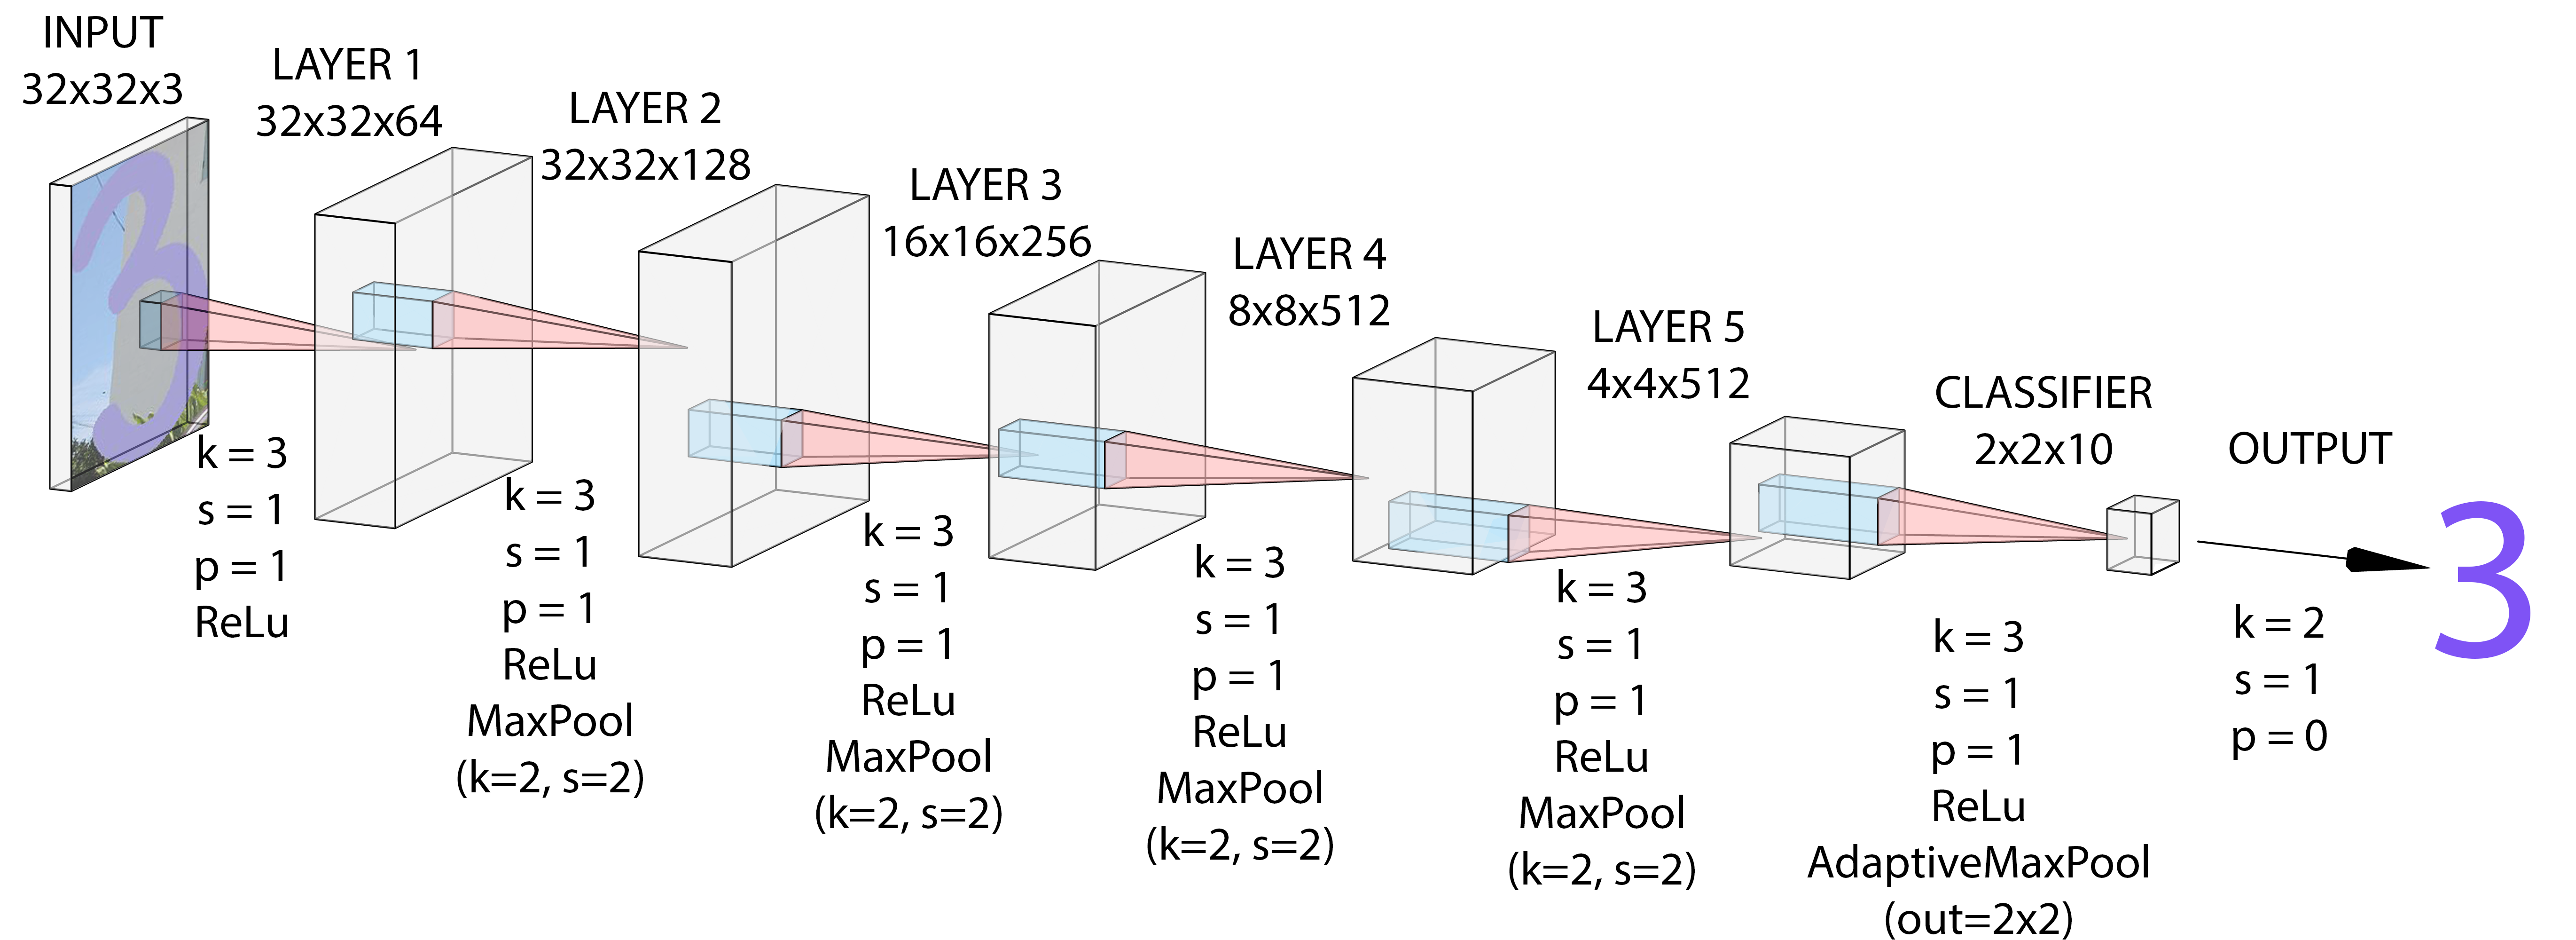

In [ ]:
class CNN1(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=10, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 5
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.AdaptiveMaxPool2d(output_size=2),
      # Classifier
      nn.Conv2d(in_channels=512, out_channels=out_size, kernel_size=2, padding=0, stride=1)
    )

  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    output = self.layers(x)
    return output.view(b, -1)

### 3.2 Second FCN

This second Fully Convolutional Network is the same as the first model but this time we deleted the layer 5.
So, it is composed by 4 layer with kernel size 3x3, padding and striding 1. The number of channel is doubled at each layer, starting from 64 to 256. The activation function used is ReLu with Max pooling of size 2x2 and striding 2.

Due to the lack of final dense layer as classifier we used a convolutional layer of 256, kernel size 2x2, padding 0 and striding 1, that will be able to classify images in the 10 predefined classes.
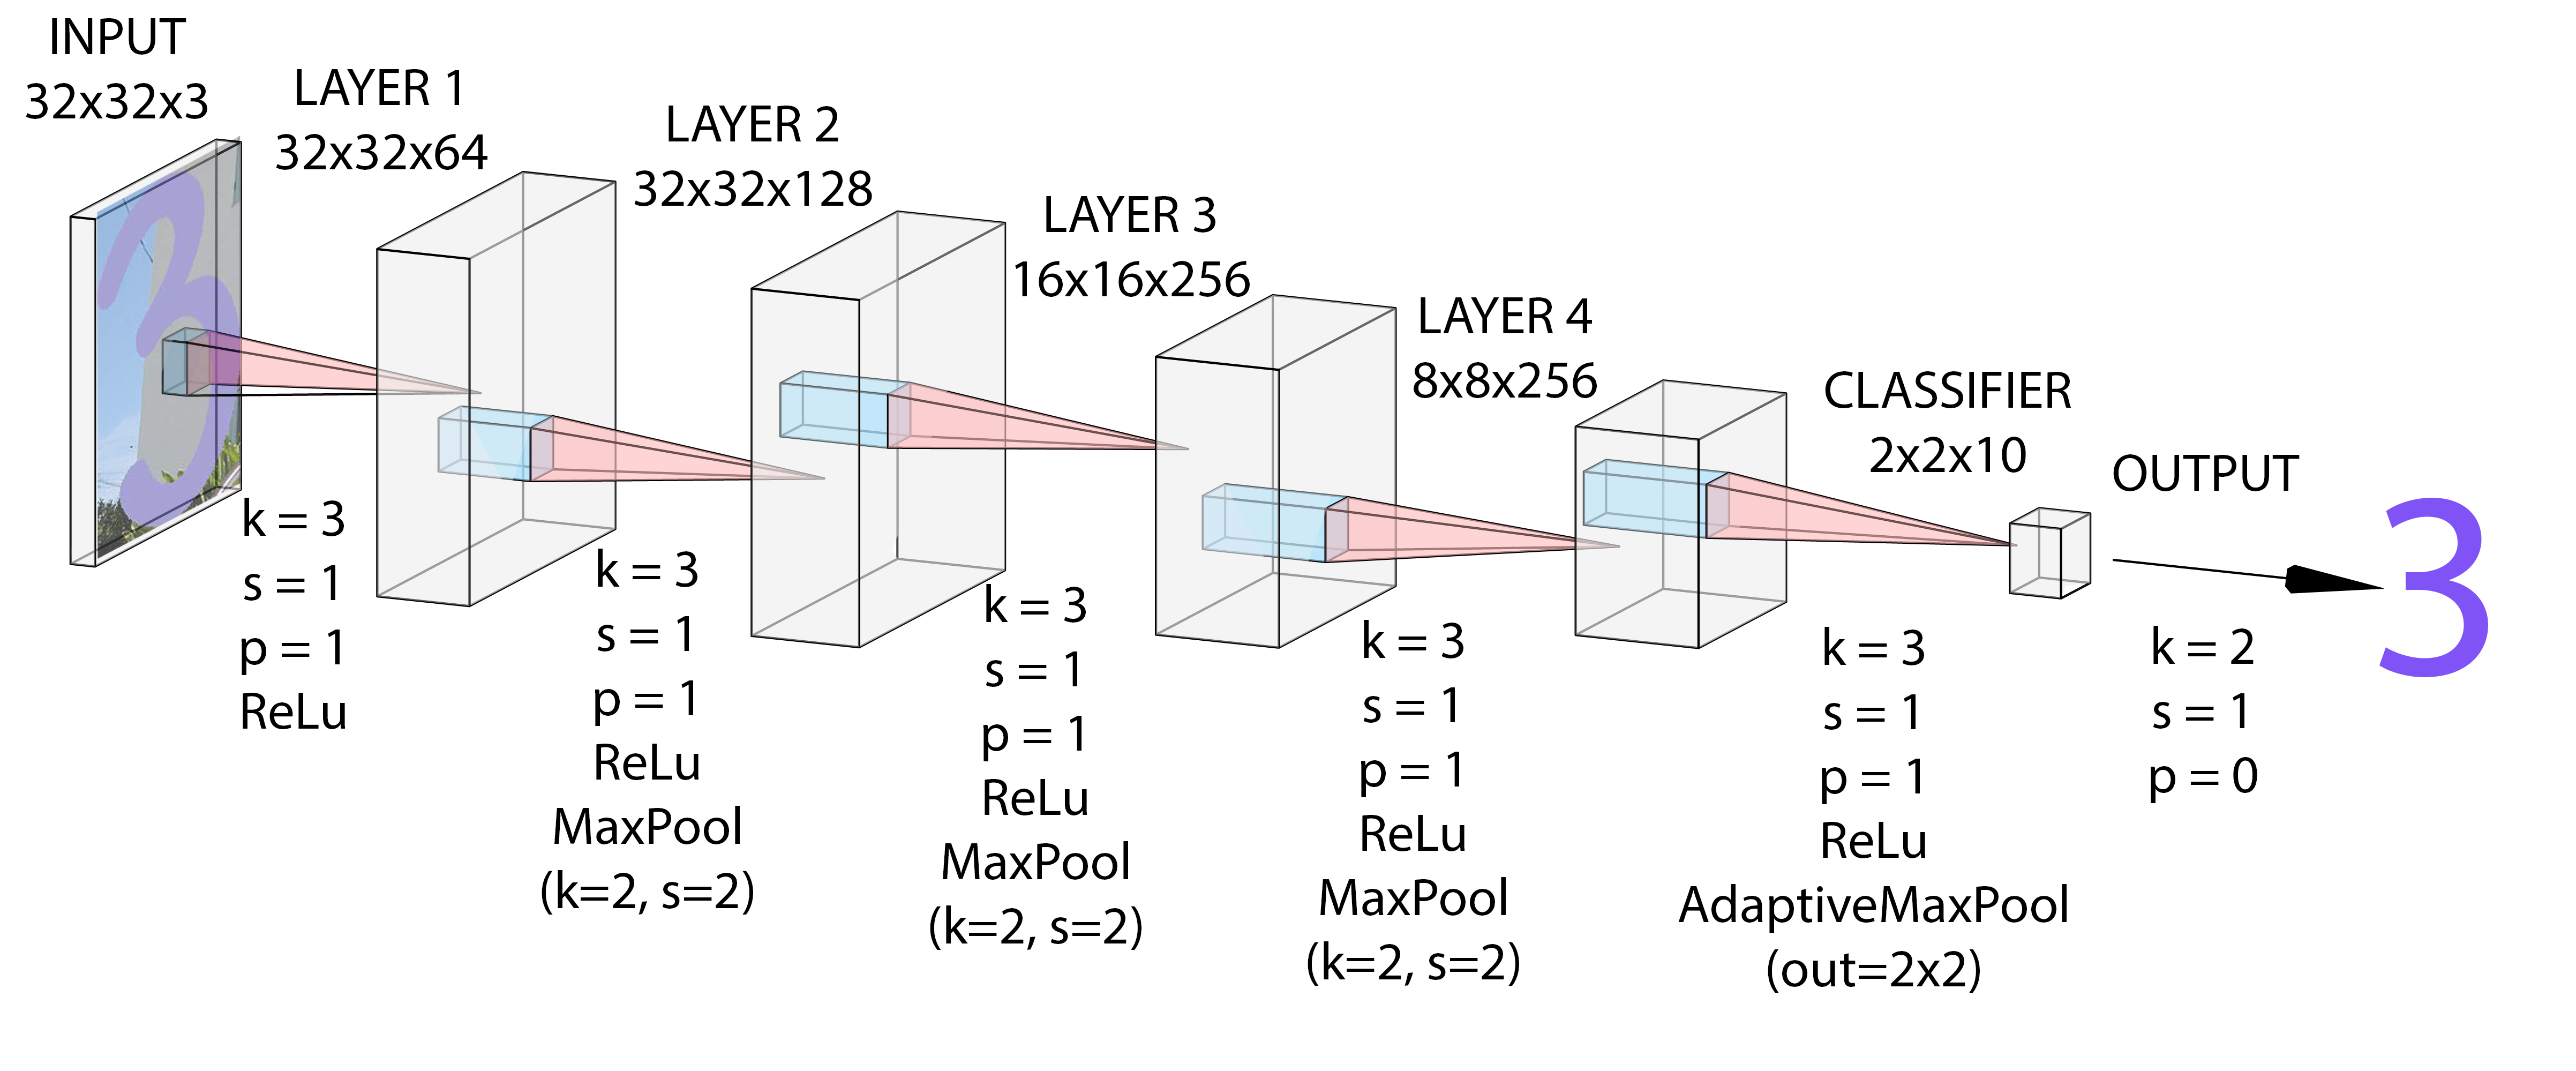

In [ ]:
class CNN2(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=10, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 4
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.AdaptiveMaxPool2d(output_size=2),
      # Classifier
      nn.Conv2d(in_channels=256, out_channels=out_size, kernel_size=2, padding=0, stride=1)
    )

  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    output = self.layers(x)
    return output.view(b, -1)

### 3.3 Third FCN

This third Fully Convolutional Network is the same as the second model but this time we deleted the layer 4.
So, it is composed by 3 layer with kernel size 3x3, padding and striding 1. The number of channel is doubled at each layer, starting from 64 to 128. The activation function used is ReLu with Max pooling of size 2x2 and striding 2.

Due to the lack of final dense layer as classifier we used a convolutional layer of 128, kernel size 2x2, padding 0 and striding 1, that will be able to classify images in the 10 predefined classes.
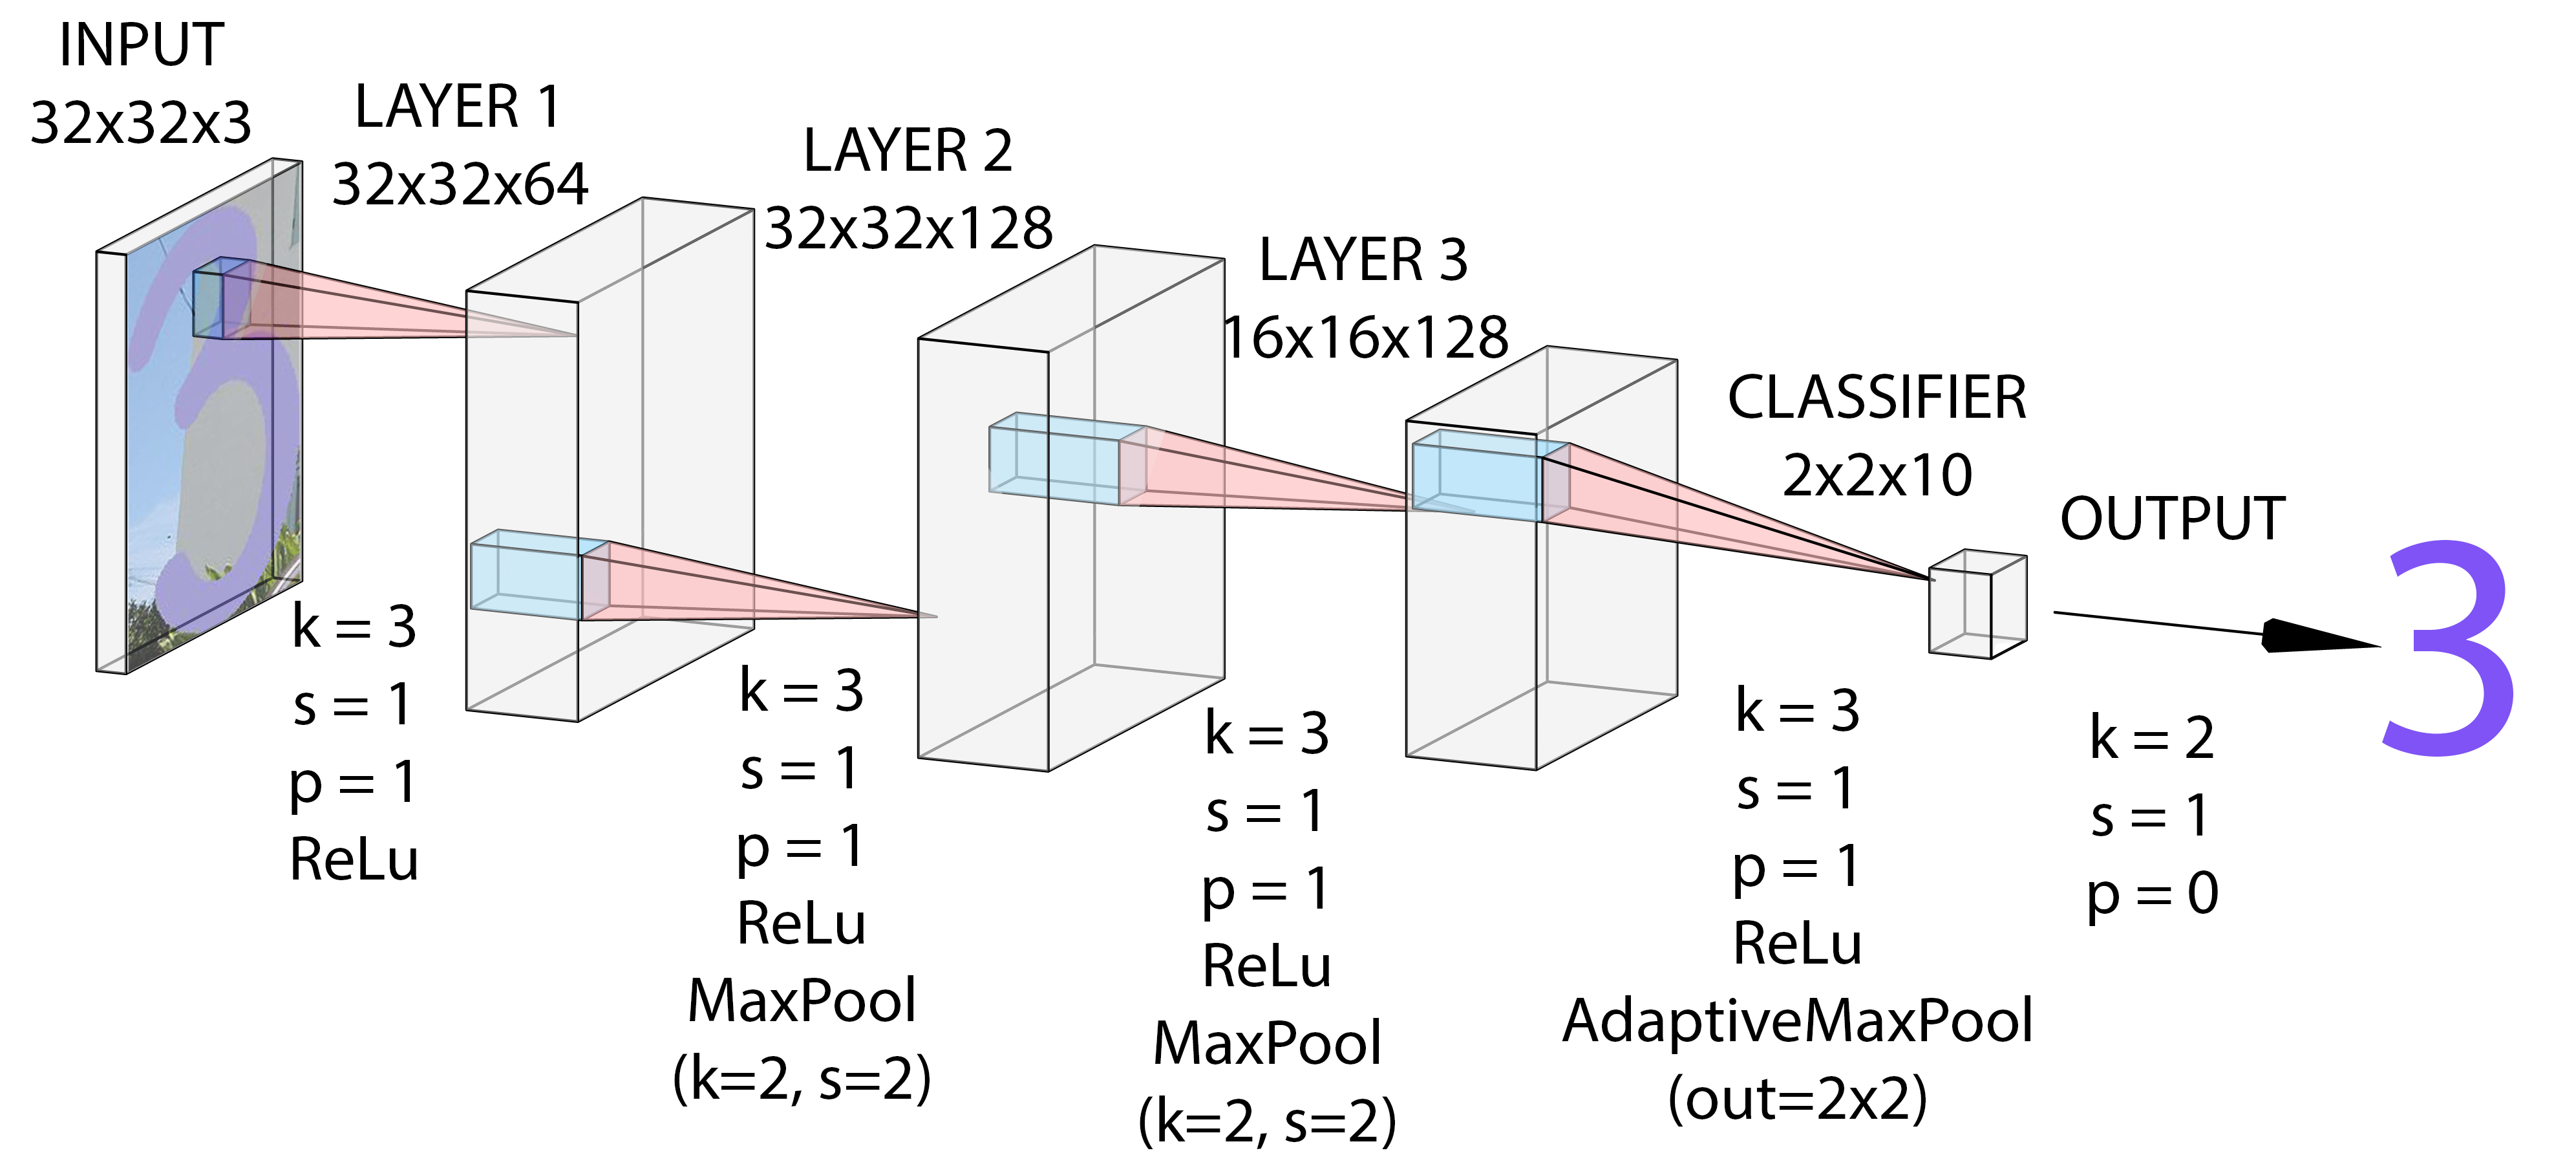

In [ ]:
class CNN3(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=10, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.AdaptiveMaxPool2d(output_size=2),
      # Classifier
      nn.Conv2d(in_channels=128, out_channels=out_size, kernel_size=2, padding=0, stride=1)
    )

  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    output = self.layers(x)
    return output.view(b, -1)

### 3.4 Fourth FCN

This fourth Fully Convolutional Network is the same as the third model but this time we deleted the layer 3.
So, it is composed by 2 layer with kernel size 3x3, padding and striding 1. The number of channel is 64, the activation function used is ReLu with Max pooling of size 2x2 and striding 2.

Due to the lack of final dense layer as classifier we used a convolutional layer of 64, kernel size 2x2, padding 0 and striding 1, that will be able to classify images in the 10 predefined classes.
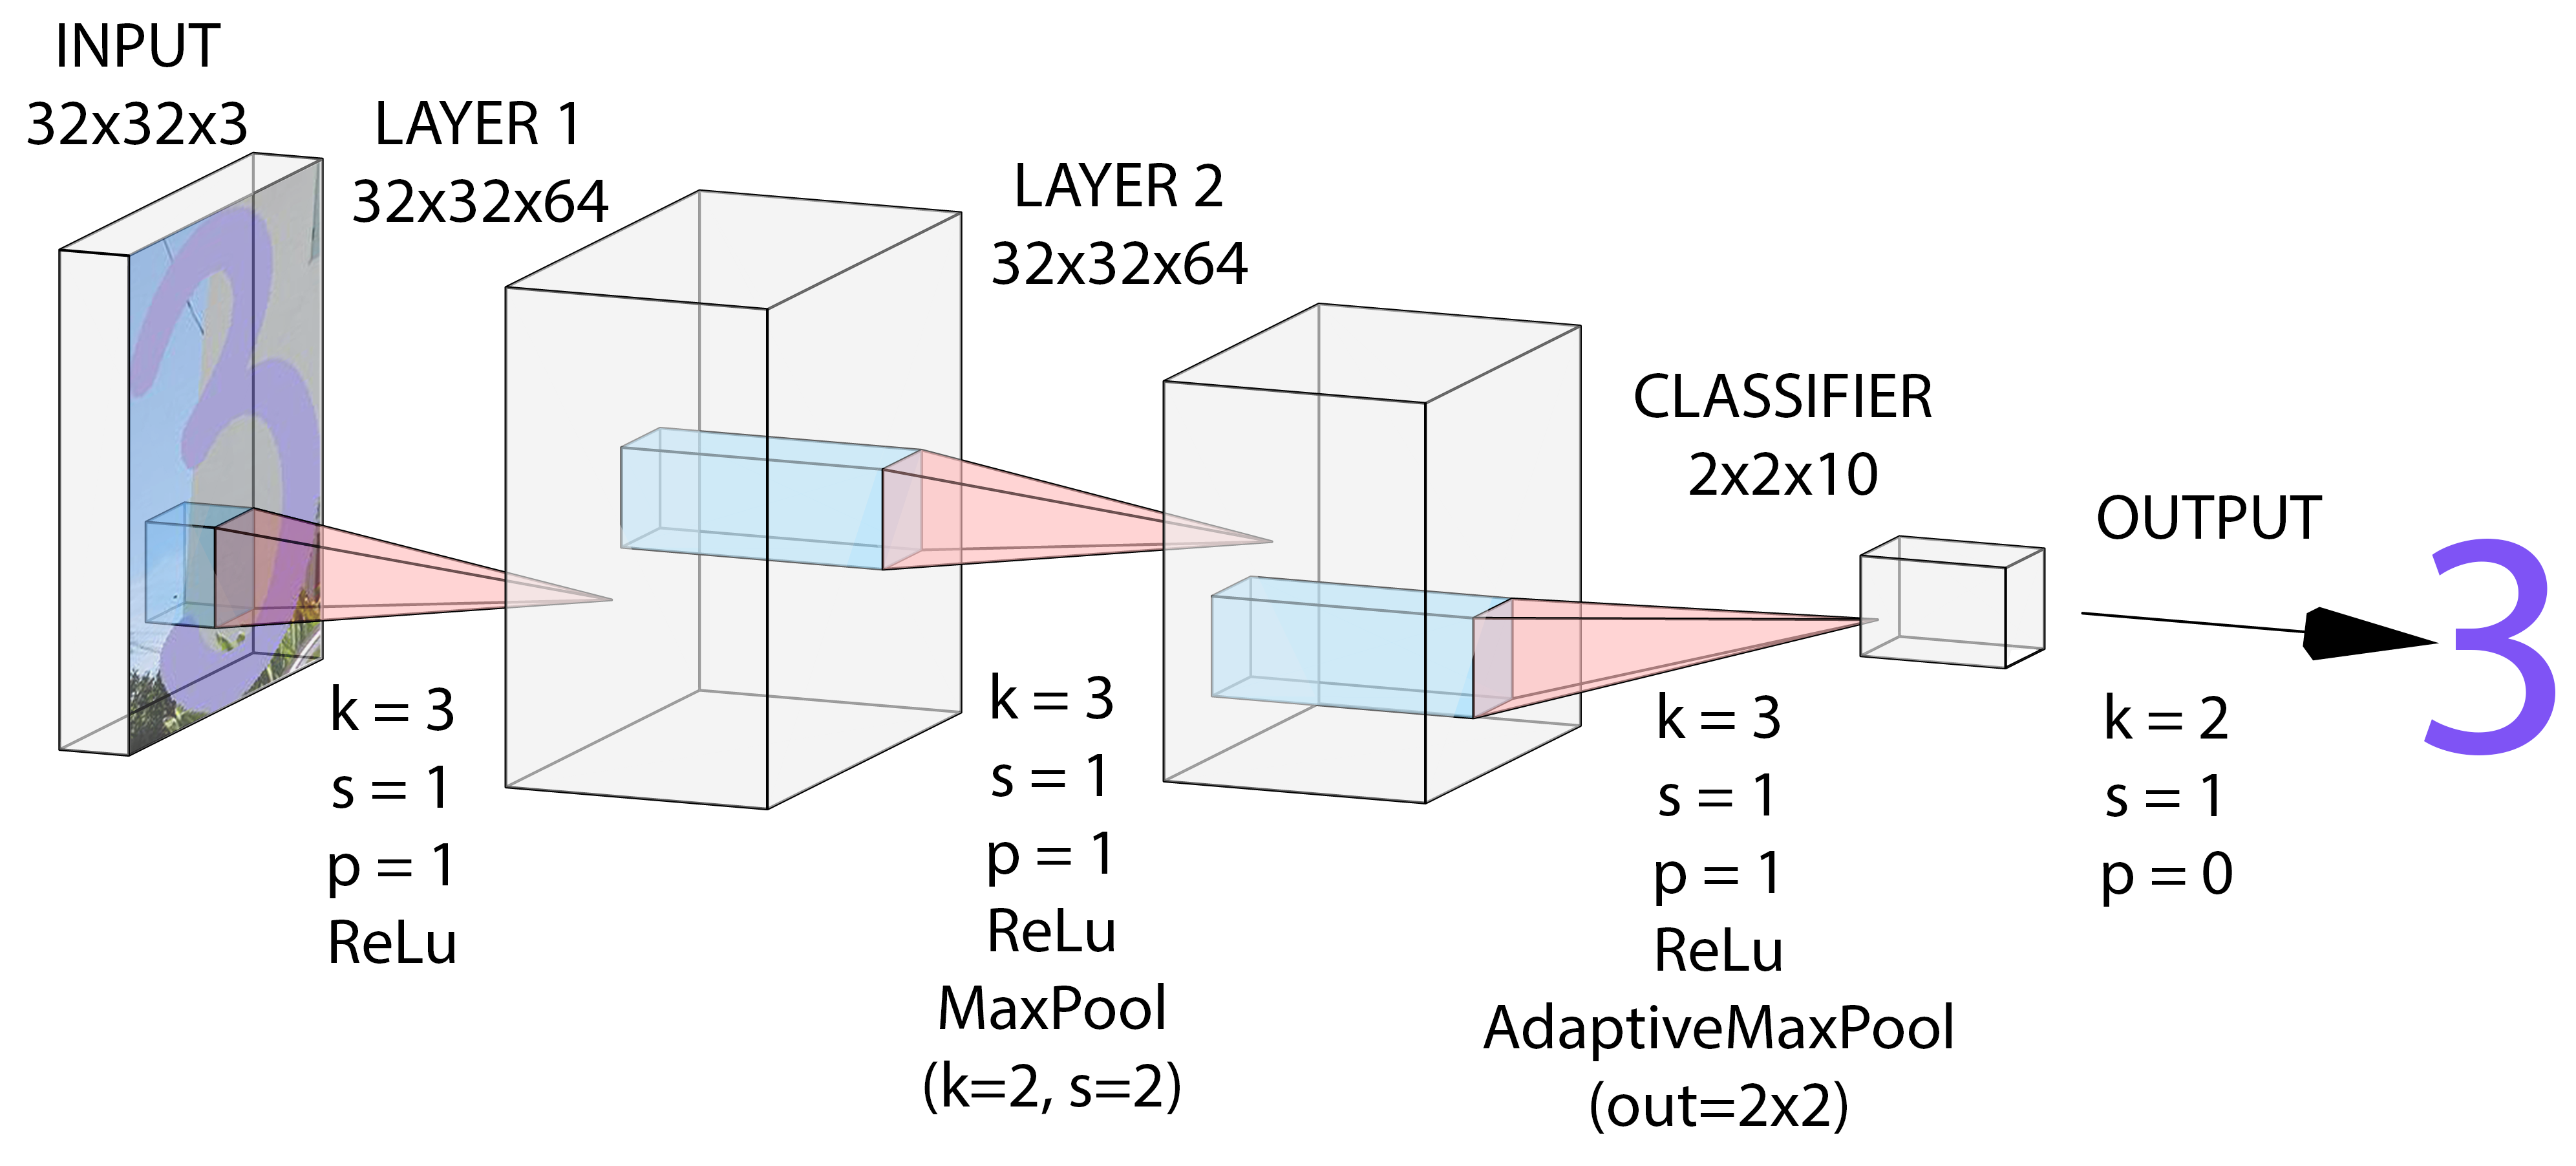

In [ ]:
class CNN4(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=10, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.AdaptiveMaxPool2d(output_size=2),
      # Classifier
      nn.Conv2d(in_channels=64, out_channels=out_size, kernel_size=2, padding=0, stride=1)
    )

  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    output = self.layers(x)
    return output.view(b, -1)

### 3.5 Classification

Here we define the training function to train, validate and test the model.

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=10, dev=torch.device("cpu"), save_param = False, model_name="my_model"):
    
    history_prediction = []
    history_label = []
    history_epoch = list()
    
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}

        # Store the best validation test accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(epochs):
            
            # Store predictions and labels for each batch
            batch_prediction = {"train": [], "val": [], "test": []}
            batch_label = {"train": [], "val": [], "test": []}
            
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)


                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy

                    # Store predictions and labels for each batch
                    batch_prediction[split].extend(pred_labels.tolist())
                    batch_label[split].extend(labels.tolist())

            # Store predictions and labels for each epoch
            history_prediction.append(batch_prediction)
            history_label.append(batch_label)

            history_epoch.append(epoch+1)

            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
              torch.save(net.state_dict(), f"{model_name}_best_val.pth")
              best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])


            # Print info
            print(f"Epoch {epoch+1}:",
                  f"Training Loss={epoch_loss['train']:.4f},",
                  f"Training Accuracy={epoch_accuracy['train']:.4f},",
                  f"Validation Loss={epoch_loss['val']:.4f},",
                  f"Validation Accuracy={epoch_accuracy['val']:.4f},",
                  f"Test Loss={epoch_loss['test']:.4f},",
                  f"Test Accuracy={epoch_accuracy['test']:.4f}")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        print()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

        # Create dataframe from dictionaries
        dict_accuracy = { "Model": model_name, "Epoch": history_epoch, "Train Accuracy": history_accuracy['train'], "Val Accuracy": history_accuracy['val'], "Test Accuracy": history_accuracy['test']}
        df_accuracy = pd.DataFrame(dict_accuracy)
        # Start index of the dataframe from 1 (as for the number of epoch)
        df_accuracy.index += 1

        # Set pandas to display the whole dataframe
        pd.set_option('display.max_columns', None)

        # Best model for validation accuracy
        val_best_model = df_accuracy.loc[[df_accuracy["Val Accuracy"].idxmax()]]
        print("\n*** Best model: ***")
        print(val_best_model)
        
        for split in ["train", "val", "test"]:
          print(f"\n{model_name} - Confusion Matrix " + split + " set")
          mat = confusion_matrix(history_prediction[(df_accuracy["Val Accuracy"].idxmax()-1)][split], history_label[(df_accuracy["Val Accuracy"].idxmax()-1)][split]) #Pay attention that this confusion matrix is actually reversed
          sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar= True, cmap = 'viridis', xticklabels=range(0,10), yticklabels=range(0,10))
          plt.ylabel('Actual class') #Pay attention that this confusion matrix is actually reversed and this is original x-axis
          plt.xlabel('Predictions') #Pay attention that this confusion matrix is actually reversed and this is original y-axis
          plt.show()    
          print(metrics.classification_report(history_label[(df_accuracy["Val Accuracy"].idxmax()-1)][split], history_prediction[(df_accuracy["Val Accuracy"].idxmax()-1)][split], zero_division = 0))
          plt.clf()

        return (val_best_model)

We define the dictionary for loaders, the criterion, optimizer and the number of epochs (which is 100 for every model used).
At the end of each training will be print the best model for epoch considering the accuracy over the validation set, a confusion matrix over all the three sets and other parameters to evaluate the goodness of the model.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}
           
criterion = nn.CrossEntropyLoss()

*** First FCN ***
CNN1(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): AdaptiveMaxPool2d(output_size=2)
    (14): Conv2d(512, 10, kernel_size=(2, 2), stride=(1, 1))
  )
)
Epoch 1: Training Loss=1.5710, Training Accuracy=0.4474, Validation Loss=0.6716, Validation Accuracy=0.8125, Test Loss=0.6583,

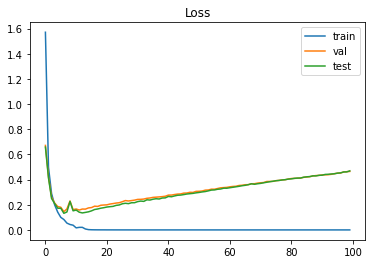

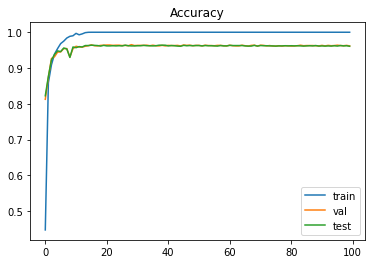


*** Best model: ***
        Model  Epoch  Train Accuracy  Val Accuracy  Test Accuracy
29  First FCN     29             1.0      0.965278       0.961806

First FCN - Confusion Matrix train set


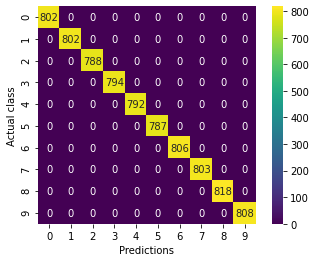

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       802
           1       1.00      1.00      1.00       802
           2       1.00      1.00      1.00       788
           3       1.00      1.00      1.00       794
           4       1.00      1.00      1.00       792
           5       1.00      1.00      1.00       787
           6       1.00      1.00      1.00       806
           7       1.00      1.00      1.00       803
           8       1.00      1.00      1.00       818
           9       1.00      1.00      1.00       808

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000


First FCN - Confusion Matrix val set


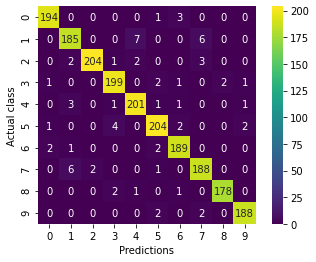

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       198
           1       0.94      0.93      0.94       198
           2       0.99      0.96      0.98       212
           3       0.96      0.97      0.96       206
           4       0.95      0.97      0.96       208
           5       0.96      0.96      0.96       213
           6       0.96      0.97      0.97       194
           7       0.94      0.95      0.95       197
           8       0.99      0.98      0.98       182
           9       0.98      0.98      0.98       192

    accuracy                           0.96      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.96      0.97      2000


First FCN - Confusion Matrix test set


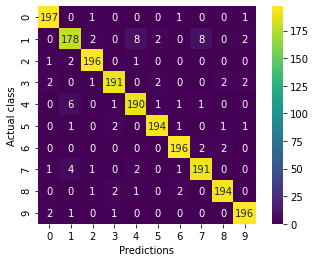

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       200
           1       0.93      0.89      0.91       200
           2       0.97      0.98      0.98       200
           3       0.97      0.95      0.96       200
           4       0.94      0.95      0.95       200
           5       0.97      0.97      0.97       200
           6       0.97      0.98      0.98       200
           7       0.95      0.95      0.95       200
           8       0.97      0.97      0.97       200
           9       0.97      0.98      0.98       200

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



<Figure size 432x288 with 0 Axes>

In [ ]:
model_name_net1 = "First FCN"
print(f"*** {model_name_net1} ***")
net1 = CNN1()
optimizer = torch.optim.Adam(net1.parameters(), lr = 0.0001)

best_model_net1 = train(net1, loaders, optimizer, criterion, epochs=100, dev=device, save_param = True, model_name = model_name_net1)

Until now we have used Accuracy as the only metric to evaluate the classification method, it is a number between 0 and 1 and measures how often the prediction is correct but it does not tell us in what way predictions are wrong, so it is considered as a rough measurement.

Precision (also called positive predictive value) tells us the percentage of our samples that were properly labeled positive, relative to all the samples labeled as positive.

Recall (also called sensitivity) tells us the percentage of positive samples that are correctly labeled.

f1 score is a combination of precision and recall (as harmonic mean) that allow us to evaluate the model when there are imbalanced classes (like in real-life classification problem).

As we can see the best model considering the validation accuracy is the 29th with Training accuracy of 100%, Validation accuracy 96.53% and test accuracy 96.18%.
*  From the Training set confusion matrix all the samples have been correctly classified.
*  In Validation set confusion matrix we can see (in f1 score) that digits "1" and "7" have been misclassified a bit rather than other digits.
*  The same apply for the test set confusion matrix (in f1 score), digits "1" and "4" have been misclassified more then in the validation set.

*** Second FCN ***
CNN2(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): AdaptiveMaxPool2d(output_size=2)
    (11): Conv2d(256, 10, kernel_size=(2, 2), stride=(1, 1))
  )
)
Epoch 1: Training Loss=2.0545, Training Accuracy=0.2546, Validation Loss=1.0868, Validation Accuracy=0.6786, Test Loss=1.0970, Test Accuracy=0.6746
Epoch 2: Training Loss=0.7819, Training Accuracy=0.7719, Validation Loss=0.5731, Validation Accuracy=0.8507, Test Loss=0.5817, Test Accuracy=0.8383
Epoch 3: 

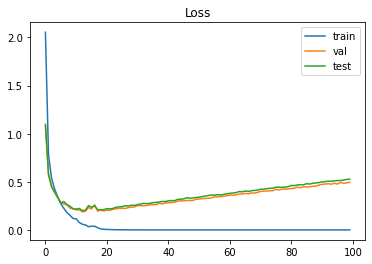

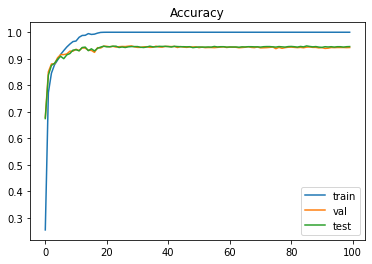


*** Best model: ***
         Model  Epoch  Train Accuracy  Val Accuracy  Test Accuracy
29  Second FCN     29             1.0      0.948413       0.945933

Second FCN - Confusion Matrix train set


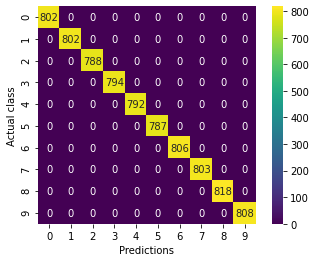

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       802
           1       1.00      1.00      1.00       802
           2       1.00      1.00      1.00       788
           3       1.00      1.00      1.00       794
           4       1.00      1.00      1.00       792
           5       1.00      1.00      1.00       787
           6       1.00      1.00      1.00       806
           7       1.00      1.00      1.00       803
           8       1.00      1.00      1.00       818
           9       1.00      1.00      1.00       808

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000


Second FCN - Confusion Matrix val set


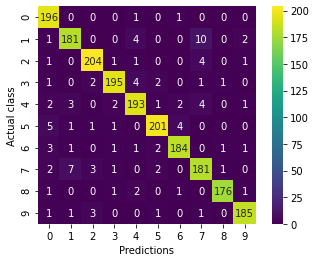

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       198
           1       0.93      0.91      0.92       198
           2       0.96      0.96      0.96       212
           3       0.97      0.95      0.96       206
           4       0.94      0.93      0.93       208
           5       0.96      0.94      0.95       213
           6       0.96      0.95      0.95       194
           7       0.90      0.92      0.91       197
           8       0.98      0.97      0.98       182
           9       0.97      0.96      0.97       192

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000


Second FCN - Confusion Matrix test set


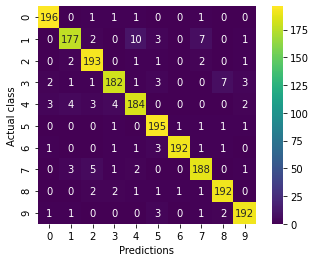

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       200
           1       0.94      0.89      0.91       200
           2       0.93      0.96      0.95       200
           3       0.95      0.91      0.93       200
           4       0.92      0.92      0.92       200
           5       0.93      0.97      0.95       200
           6       0.99      0.96      0.97       200
           7       0.93      0.94      0.94       200
           8       0.95      0.96      0.95       200
           9       0.96      0.96      0.96       200

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



<Figure size 432x288 with 0 Axes>

In [ ]:
model_name_net2 = "Second FCN"
print(f"*** {model_name_net2} ***")
net2 = CNN2()
optimizer = torch.optim.Adam(net2.parameters(), lr = 0.0001)

best_model_net2 = train(net2, loaders, optimizer, criterion, epochs=100, dev=device, save_param = True, model_name = model_name_net2)

As we can see the best model considering the validation accuracy is the 29th with Training accuracy of 100%, Validation accuracy 94.84% and test accuracy 94.59%.
*  From the Training set confusion matrix all the samples have been correctly classified.
*  In Validation set confusion matrix we can see (in f1 score) that digits "1" and "7" have been misclassified a bit rather than other digits.
*  The same apply for the test set confusion matrix (in f1 score), digits "1" and "4" have been misclassified more than in the validation set.

*** Third FCN ***
CNN3(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): AdaptiveMaxPool2d(output_size=2)
    (8): Conv2d(128, 10, kernel_size=(2, 2), stride=(1, 1))
  )
)
Epoch 1: Training Loss=2.2947, Training Accuracy=0.1224, Validation Loss=2.2745, Validation Accuracy=0.1632, Test Loss=2.2780, Test Accuracy=0.1597
Epoch 2: Training Loss=2.1364, Training Accuracy=0.2685, Validation Loss=1.8073, Validation Accuracy=0.4861, Test Loss=1.8254, Test Accuracy=0.4816
Epoch 3: Training Loss=1.3510, Training Accuracy=0.6128, Validation Loss=1.0338, Validation Accuracy=0.7113, Test Loss=1.0450, Test Accuracy=0.7004
Epoch 4: Training Loss=0.8919, Training A

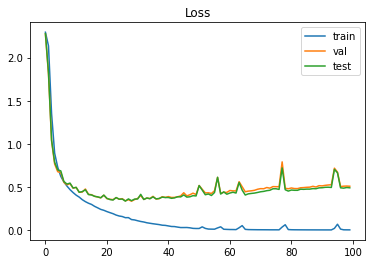

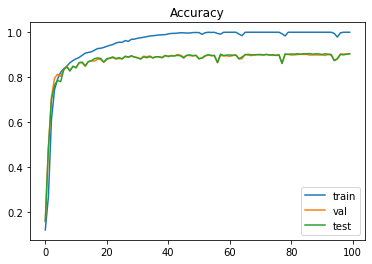


*** Best model: ***
         Model  Epoch  Train Accuracy  Val Accuracy  Test Accuracy
100  Third FCN    100             1.0      0.905258       0.904266

Third FCN - Confusion Matrix train set


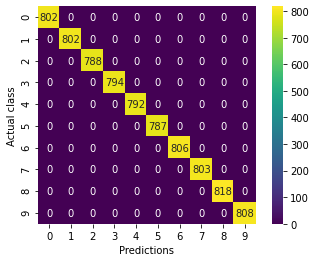

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       802
           1       1.00      1.00      1.00       802
           2       1.00      1.00      1.00       788
           3       1.00      1.00      1.00       794
           4       1.00      1.00      1.00       792
           5       1.00      1.00      1.00       787
           6       1.00      1.00      1.00       806
           7       1.00      1.00      1.00       803
           8       1.00      1.00      1.00       818
           9       1.00      1.00      1.00       808

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000


Third FCN - Confusion Matrix val set


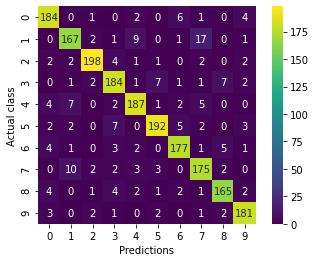

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       198
           1       0.88      0.84      0.86       198
           2       0.95      0.93      0.94       212
           3       0.88      0.89      0.89       206
           4       0.90      0.90      0.90       208
           5       0.93      0.90      0.91       213
           6       0.91      0.91      0.91       194
           7       0.85      0.89      0.87       197
           8       0.91      0.91      0.91       182
           9       0.92      0.94      0.93       192

    accuracy                           0.91      2000
   macro avg       0.90      0.91      0.90      2000
weighted avg       0.91      0.91      0.91      2000


Third FCN - Confusion Matrix test set


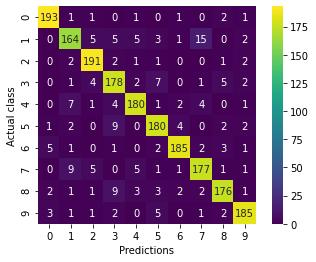

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       200
           1       0.87      0.82      0.84       200
           2       0.91      0.95      0.93       200
           3       0.85      0.89      0.87       200
           4       0.91      0.90      0.91       200
           5       0.89      0.90      0.89       200
           6       0.94      0.93      0.93       200
           7       0.88      0.89      0.88       200
           8       0.92      0.88      0.90       200
           9       0.93      0.93      0.93       200

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



<Figure size 432x288 with 0 Axes>

In [ ]:
model_name_net3 = "Third FCN"
print(f"*** {model_name_net3} ***")
net3 = CNN3()
optimizer = torch.optim.Adam(net3.parameters(), lr = 0.0001)

best_model_net3 = train(net3, loaders, optimizer, criterion, epochs=100, dev=device, save_param = True, model_name = model_name_net3)

As we can see the best model considering the validation accuracy is the 100th with Training accuracy of 100%, Validation accuracy 90.53% and test accuracy 90.43%.
*  From the Training set confusion matrix all the samples have been correctly classified.
*  In Validation set confusion matrix we can see (in f1 score) that digits "1" and "7" have been misclassified a bit rather than other digits.
*  The same apply for the test set confusion matrix (in f1 score), digits "1" and "3" have been misclassified more than in the validation set.

*** Fourth FCN ***
CNN4(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AdaptiveMaxPool2d(output_size=2)
    (5): Conv2d(64, 10, kernel_size=(2, 2), stride=(1, 1))
  )
)
Epoch 1: Training Loss=2.2989, Training Accuracy=0.1192, Validation Loss=2.2911, Validation Accuracy=0.1384, Test Loss=2.2922, Test Accuracy=0.1354
Epoch 2: Training Loss=2.2806, Training Accuracy=0.1566, Validation Loss=2.2740, Validation Accuracy=0.1711, Test Loss=2.2759, Test Accuracy=0.1771
Epoch 3: Training Loss=2.2554, Training Accuracy=0.2072, Validation Loss=2.2462, Validation Accuracy=0.1830, Test Loss=2.2487, Test Accuracy=0.1766
Epoch 4: Training Loss=2.2142, Training Accuracy=0.2527, Validation Loss=2.1958, Validation Accuracy=0.2644, Test Loss=2.2017, Test Accuracy=0.2713
Epoch 5: Training Loss=2.1502, Training Accuracy=0.3034, Validation Los

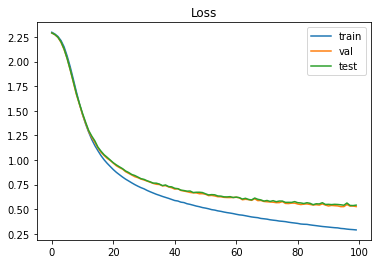

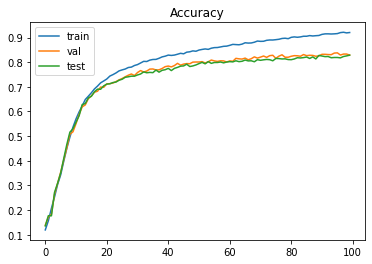


*** Best model: ***
         Model  Epoch  Train Accuracy  Val Accuracy  Test Accuracy
96  Fourth FCN     96        0.915875      0.837798       0.818948

Fourth FCN - Confusion Matrix train set


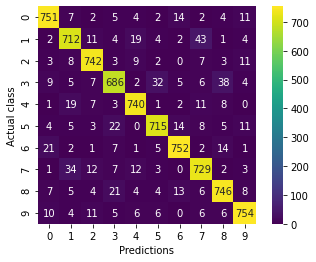

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       802
           1       0.89      0.89      0.89       802
           2       0.93      0.94      0.93       788
           3       0.90      0.86      0.88       794
           4       0.93      0.93      0.93       792
           5       0.92      0.91      0.92       787
           6       0.94      0.93      0.94       806
           7       0.89      0.91      0.90       803
           8       0.90      0.91      0.91       818
           9       0.93      0.93      0.93       808

    accuracy                           0.92      8000
   macro avg       0.92      0.92      0.92      8000
weighted avg       0.92      0.92      0.92      8000


Fourth FCN - Confusion Matrix val set


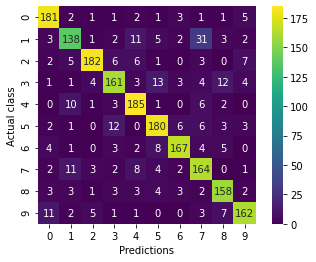

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       198
           1       0.79      0.70      0.74       198
           2       0.92      0.86      0.89       212
           3       0.83      0.78      0.80       206
           4       0.84      0.89      0.86       208
           5       0.83      0.85      0.84       213
           6       0.90      0.86      0.88       194
           7       0.73      0.83      0.78       197
           8       0.83      0.87      0.85       182
           9       0.87      0.84      0.86       192

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000


Fourth FCN - Confusion Matrix test set


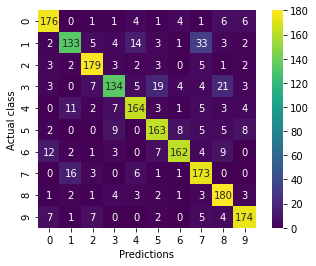

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       200
           1       0.80      0.67      0.72       200
           2       0.87      0.90      0.88       200
           3       0.81      0.67      0.73       200
           4       0.83      0.82      0.82       200
           5       0.80      0.81      0.81       200
           6       0.89      0.81      0.85       200
           7       0.73      0.86      0.79       200
           8       0.78      0.90      0.83       200
           9       0.86      0.87      0.87       200

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



<Figure size 432x288 with 0 Axes>

In [ ]:
model_name_net4 = "Fourth FCN"
print(f"*** {model_name_net4} ***")
net4 = CNN4()
optimizer = torch.optim.Adam(net4.parameters(), lr = 0.0001)

best_model_net4 = train(net4, loaders, optimizer, criterion, epochs=100, dev=device, save_param = True, model_name = model_name_net4)

As we can see the best model considering the validation accuracy is the 96th with Training accuracy of 91.59%, Validation accuracy 83.78% and test accuracy 81.89%.
*  From the Training set confusion matrix we can see (in f1 score) that digits "1" and "3" have been misclassified a bit rather than other digits.
*  In Validation set confusion matrix we can see (in f1 score) that digits "1" and "7" have been misclassified a bit rather than other digits.
*  The same apply for the test set confusion matrix (in f1 score), digits "1", "3" and "7" have been misclassified more than in the validation set.

## 4. Conclusion

This table should be useful to summirize the accuracy over the models, we selected the best model for the best epoch for each of the four FCN.

In [ ]:
results = pd.concat([best_model_net1, best_model_net2, best_model_net3, best_model_net4])
print(results.to_string(index=False))

      Model  Epoch  Train Accuracy  Val Accuracy  Test Accuracy
  First FCN     29        1.000000      0.965278       0.961806
 Second FCN     29        1.000000      0.948413       0.945933
  Third FCN    100        1.000000      0.905258       0.904266
 Fourth FCN     96        0.915875      0.837798       0.818948


As we can see the best FCN is the first with more layers, with an accuracy on the training set of 100%, validation 96.53% and test set 96.18%.

Remembering that in each model the architectures usally misclassify digits "1", "4" and "7".